In [1]:
import pandas as pd

orders_data = pd.read_csv('./orders.csv') # orders
order_products__prior_data = pd.read_csv('./order_products__prior.csv') # order_products__prior
products_data = pd.read_csv('./products.csv') # products
aisles_data = pd.read_csv('./aisles.csv') # aisles
order_products__train_data = pd.read_csv('./order_products__train.csv') # order_products_train

new_orders = orders_data.drop(orders_data[orders_data['eval_set'] == 'test'].index, axis=0) # test drop한 orders

order_products_data = pd.merge(order_products__prior_data, order_products__train_data, how='outer') # prior + train

orders_products = pd.merge(order_products_data, new_orders, on='order_id') # orders + order_products

mean_prior_order_by_users = new_orders.groupby('user_id')['days_since_prior_order'].mean().round() # 구매주기 평균 구하기

In [2]:
# 이탈자 데이터 프레임 구하기

import numpy as np
churn_days = 27 # 이탈 구매 주기

mean_prior_order_by_users = pd.DataFrame(mean_prior_order_by_users)
mean_prior_order_by_users['days_since_prior_order'] = np.where(mean_prior_order_by_users['days_since_prior_order'] >= churn_days, True, False)
mean_prior_order_by_users.rename(columns={'days_since_prior_order':'churn'}, inplace=True)

In [4]:
# 평균 cart 제품에 따른 데이터 프레임 구하기

orders_products_count = orders_products.groupby('order_id').size()
orders_products_count = pd.DataFrame(orders_products_count)
orders_products_count = orders_products_count.rename(columns={0: 'carts'})
orders_products_count['carts'] = np.where(orders_products_count['carts'] >= 10, '평균 이상', '평균 이하') # 장바구니 평균 개수인 10개가 이상이라면 평균 이상, 아니면 평균 이하

p1 = pd.merge(orders_products, orders_products_count, on='order_id') # order_products와 join
p2 = pd.merge(p1, mean_prior_order_by_users, on='user_id') # 이탈 dataframe과 join

In [4]:
p2 = pd.merge(orders_products, mean_prior_order_by_users, on='user_id') # 이탈 dataframe과 join

In [7]:
# churn이 True/False이면서 carts가 '평균 이하'/'평균 이상' 인 사용자 추출

#filtered_users = p2[(p2['churn']) & (p2['carts'] == '평균 이하')] # 이탈자 이면서 평균이하
filtered_users = p2[(p2['churn']== False) & (p2['carts'] == '평균 이하')] # 비이탈자이면서 평균이하

# 전체 사용자 수와 조건을 만족하는 사용자 수 계산
total_users = p2['user_id'].nunique()
filtered_users_count = filtered_users['user_id'].nunique()

# 비율 계산
ratio = filtered_users_count / total_users

print(f"Churn이 True이면서 carts가 '평균 이하'인 사용자의 비율: {ratio:.2%}")

Churn이 True이면서 carts가 '평균 이하'인 사용자의 비율: 69.55%


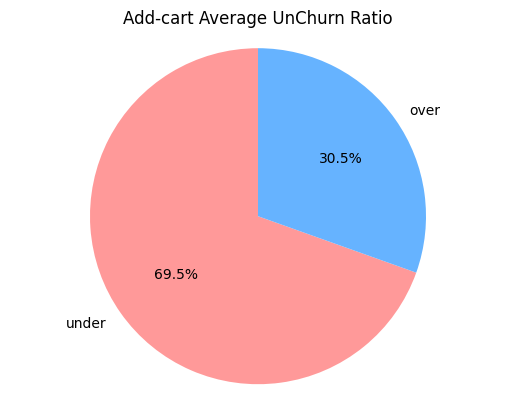

In [8]:
import matplotlib.pyplot as plt

labels = ['under', 'over']
sizes = [ratio, 1 - ratio]
colors = ['#ff9999','#66b3ff']

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

#plt.title('Add-cart Average Churn Ratio') # 이탈자
plt.title('Add-cart Average UnChurn Ratio') # 비이탈자
plt.show()

In [26]:
#mean_prior_order_by_users = new_orders.groupby('user_id')['days_since_prior_order'].mean().round() # 구매주기 평균 구하기
mean_prior_order_by_users['churn'].apply(lambda x:x==True).sum()

15114

In [27]:
15114/206209 * 100

7.329457007211131

In [24]:
mean_prior_order_by_users = new_orders.groupby('user_id')['days_since_prior_order'].mean().round() # 구매주기 평균 구하기

In [13]:
import numpy as np

# 이탈자들의 구매시간 데이터
churned_data = p2[p2['churn'] == True]['order_hour_of_day'].dropna().values

# 비이탈자들의 구매시간 데이터
not_churned_data = p2[p2['churn'] == False]['order_hour_of_day'].dropna().values

# 독립표본 t-검정 수행
t_stat, p_value = stats.ttest_ind(churned_data, not_churned_data, equal_var=True)
print("이탈자와 비이탈자의 오전 구매시간 t-statistic:", t_stat)
print("p-value:", p_value)

이탈자와 비이탈자의 오전 구매시간 t-statistic: 55.31765884268559


0.0

In [19]:
t_stat, p_value = stats.ttest_ind(morning_churned, afternoon_churned, equal_var=True)
t_stat, p_value

(-958.4296044845877, 0.0)

In [6]:
import scipy.stats as stats

# 이탈자와 비이탈자 데이터 추출
churned_data = p2[p2['churn'] == True]

# 이탈자의 오전과 오후 구매 비율 계산
churned_purchase_ratio = churned_data['order_hour_of_day'].apply(lambda x: 'morning' if x < 12 else 'afternoon').value_counts(normalize=True)

# 결과 출력
print("이탈자의 오전과 오후 구매 비율:")
print(churned_purchase_ratio)

# 오전과 오후 비율 데이터를 기반으로 독립표본 t-검정 수행
t_stat, p_value = stats.ttest_1samp(churned_purchase_ratio, 0.5)
print("\n오전과 오후 구매 비율에 대한 t-statistic:", t_stat)
print("p-value:", p_value)


이탈자의 오전과 오후 구매 비율:
order_hour_of_day
afternoon    0.687446
morning      0.312554
Name: proportion, dtype: float64

오전과 오후 구매 비율에 대한 t-statistic: 0.0
p-value: 1.0


In [9]:
# 이탈자와 비이탈자 데이터 추출
churned_data = p2[p2['churn'] == False]

# 이탈자의 오전과 오후 구매 비율 계산
churned_purchase_ratio = churned_data['order_hour_of_day'].apply(lambda x: 'morning' if x < 12 else 'afternoon').value_counts(normalize=True)

# 결과 출력
print("이탈자의 오전과 오후 구매 비율:")
print(churned_purchase_ratio)

# 오전과 오후 비율 데이터를 기반으로 독립표본 t-검정 수행
t_stat, p_value = stats.ttest_1samp(churned_purchase_ratio, 0.5)
print("\n오전과 오후 구매 비율에 대한 t-statistic:", t_stat)
print("p-value:", p_value)

이탈자의 오전과 오후 구매 비율:
order_hour_of_day
afternoon    0.646722
morning      0.353278
Name: proportion, dtype: float64

오전과 오후 구매 비율에 대한 t-statistic: 0.0
p-value: 1.0


In [16]:
churned_data['order_hour_of_day']

0            9
1            9
2            9
3            9
4            9
            ..
33819101    16
33819102    16
33819103    16
33819104    16
33819105    16
Name: order_hour_of_day, Length: 33139985, dtype: int64

In [14]:
morning_churned.sum()

1914529

In [15]:
morning_churned.info()

<class 'pandas.core.series.Series'>
Index: 212262 entries, 20125 to 33819002
Series name: order_hour_of_day
Non-Null Count   Dtype
--------------   -----
212262 non-null  int64
dtypes: int64(1)
memory usage: 3.2 MB
